# A (very) simple ecosystem carbon cycle model written in Python

First, we import some necessary python packages:

In [15]:
import numpy as np
import matplotlib.pyplot as plt

Next, load meteorological driving data from the provided file

In [16]:
data=np.loadtxt('met_data.txt',delimiter=',')
T_day=data[:,1]
PAR_day=data[:,0]

# Time step and length of simulation
dt=1; # days
nsteps=365*120

T=np.tile(T_day,nsteps//len(T_day));
T=T+273.15;
PAR=np.tile(PAR_day,nsteps//len(PAR_day));

Here we define a function for running a simulation using the model

In [17]:

def run_model(warming_per_year=0.0,
              disturbance_frac=0.0,
              disturbance_time=30,disturbance_removed=0.7,disturbance_CO2=0.0,
              verbose=False
              ):


    # Relationship between LAI and plant biomass
    LAI_biomass_fraction=3.5e-4;
    # Saturation value for LAI
    LAI_sat=3.5;
    # Rate parameter for photosynthesis
    photosynthesis_factor=0.02;
    # Photosynthetically active radiation
    # PAR=500;
    # Autotrophic respiration rate (fraction of biomass per day)
    Ra_rate=7e-5;
    # Tree mortality biomass loss rate (fraction of biomass per day)
    mortality_rate=2e-4;
    # Heterotrophic respiration rate (Fraction per day)
    Rh_rate=3e-5;
    # Temperature (K)
    # T=293;
    # Reference temperature
    T0=273.15;
    # Rh temperature sensitivity
    Q10_h=2.0;
    # Ra temperature sensitivity
    Q10_a=1.5;

    # Initial values for carbon pools
    initial_biomass=2000.0;
    initial_soil_carbon=6000.0;

    # Initialize carbon pools
    biomass=np.ma.masked_all(nsteps);biomass[0]=initial_biomass;
    soil_carbon=np.ma.masked_all(nsteps);soil_carbon[0]=initial_soil_carbon;
    CO2=np.ma.masked_all(nsteps);CO2[0]=0.0;

    photosynthesis=np.ma.masked_all(nsteps);
    mortality=np.ma.masked_all(nsteps);
    Ra=np.ma.masked_all(nsteps);Rh=np.ma.masked_all(nsteps);

    # Start the model iterations
    for step in range(1,nsteps):
        if step%365==0 and verbose:
            print ('Year: %d'%(step/365))

        T_current = T[step-1]+warming_per_year*step/365.0

        # Photosynthesis
        LAI=biomass[step-1]*LAI_biomass_fraction;
        photosynthesis[step-1]=LAI/(LAI+LAI_sat)*PAR[step-1]*photosynthesis_factor*dt;

        # Plants accumulate biomass from photosynthesis and lose carbon to
        # autotrophic respiration and mortality
        mortality[step-1]=biomass[step-1]*mortality_rate*dt;

        if step%(disturbance_time*365)==0:
            disturbance=biomass[step-1]*disturbance_frac;
        else:
            disturbance=0.0

        Ra[step-1]= biomass[step-1]*Ra_rate*Q10_a**((T_current-T0)/10)*dt;
        biomass[step]=biomass[step-1]+photosynthesis[step-1] - Ra[step-1] - mortality[step-1] - disturbance;


        # Soil respiration
        Rh[step-1] = Rh_rate*soil_carbon[step-1]*Q10_h**((T_current-T0)/10)*dt;

        soil_carbon[step] = soil_carbon[step-1] + mortality[step-1] - Rh[step-1] + disturbance*(1-disturbance_removed-disturbance_CO2);

        CO2[step]=CO2[step-1] + Ra[step-1] + Rh[step-1] + disturbance*disturbance_CO2;

        mortality[step-1]=mortality[step-1]+disturbance

    return {'biomass':biomass,
            'LAI':LAI,
            'photosynthesis':photosynthesis,
            'mortality':mortality,
            'Ra':Ra,
            'Rh':Rh,
            'soil_carbon':soil_carbon,
            'CO2':CO2}


And a function for plotting output ffrom different model runs

In [18]:
def plot_model_comp(f,model_data,style='-',do_legend=True,only_avg=True):
    a=f.axes[0]
    t=np.arange(nsteps,dtype=float)/365;
    biomass=a.plot(t,model_data['biomass']/1e3,'g',ls=style,label='Biomass')
    soilC=a.plot(t,model_data['soil_carbon']/1e3,c='brown',ls=style,label='Soil C')
    if do_legend:
        l=a.legend([biomass[0],soilC[0]],['Biomass','Soil and litter'],loc='upper left');l.get_frame().set_alpha(0.5)
    a.set_xlabel('Time (years)')
    a.set_ylabel('Carbon (kgC/m2)')
    a.set_title('Carbon pools')

    a=(f.axes[1])
    nyears=nsteps//365-1;
    t_avg=np.zeros(nyears);
    psyn_avg=np.zeros(nyears);
    Ra_avg=np.zeros(nyears);
    Rh_avg=np.zeros(nyears);
    mort_avg=np.zeros(nyears);
    for n in range(int(nsteps/365)-1):
        t_avg[n]=n;
        psyn_avg[n]=(model_data['photosynthesis'][n*365:(n+1)*365]).mean()
        Ra_avg[n]=(model_data['Ra'][n*365:(n+1)*365]).mean()
        Rh_avg[n]=(model_data['Rh'][n*365:(n+1)*365]).mean()
        mort_avg[n]=(model_data['mortality'][n*365:(n+1)*365]).mean()


    p=a.plot(t_avg,psyn_avg-Ra_avg,'g',ls=style,label='Plant growth');
    # m=plot(t_avg,mort_avg,'m',ls=style,label='Mortality');
    rt=a.plot(t_avg,(Rh_avg),c='brown',ls=style,label='Decomposition');
    nep=a.plot(t_avg,-Rh_avg-Ra_avg+psyn_avg,'k',ls=style,label='Net C uptake');
    if not only_avg:
        a.lot(t,model_data['photosynthesis'],'g',ls=style,label='Plant growth')
        a.plot(t,model_data['Rh'],c='brown',ls=style,label='Decomposition')
        a.plot(t,-model_data['Rh']-model_data['Ra']+model_data['photosynthesis'],c='k',ls=style,label='Net C uptake')
    a.plot([min(t_avg),max(t_avg)],[0,0],'k:')
    a.set_xlabel('Time (years)')
    a.set_ylabel('Carbon flow (kgC/m2/year)')
    a.set_title('Annual average C flows')
    if do_legend:
        l=a.legend(loc='upper left');l.get_frame().set_alpha(0.5)

Run the baseline model with no modifications, and plot the results

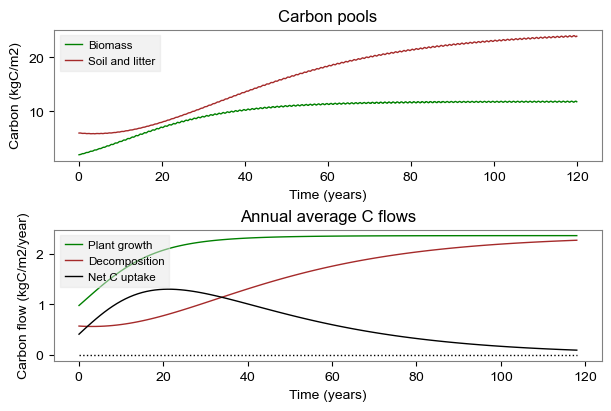

In [19]:
baseline = run_model()
f,a=plt.subplots(nrows=2,clear=True,num='Baseline',dpi=100)
plot_model_comp(f,baseline)

Next we'll run a simulation that includes periodic removal of plant biomass to represent logging, and compare it with the baseline:

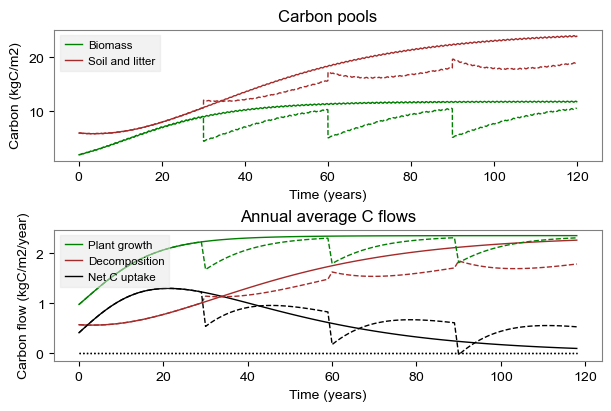

In [20]:
logging = run_model(disturbance_frac=0.5,disturbance_removed=0.7,disturbance_CO2=0.0)

f,a=plt.subplots(nrows=2,clear=True,num='Logging comparison',dpi=100)
plot_model_comp(f,baseline,'-')
plot_model_comp(f,logging,'--',do_legend=False)

Then we'll do a similar comparison with a warming trend applied to the temperature data:

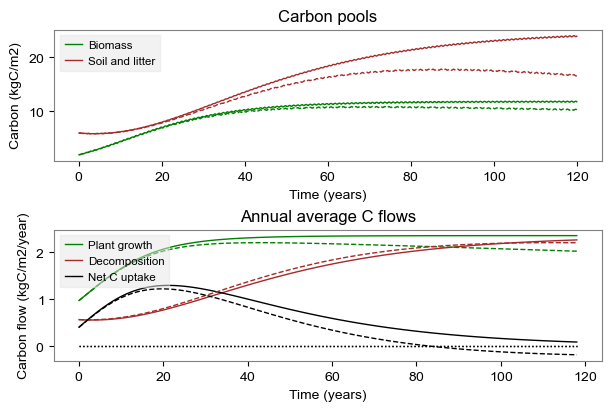

In [21]:
warming = run_model(warming_per_year=4.0/100)

f,a=plt.subplots(nrows=2,clear=True,num='Warming comparison',dpi=100)
plot_model_comp(f,baseline,'-')
plot_model_comp(f,warming,'--',do_legend=False)

Finally, we plot the simulated fluxes from the baseline simulation:

Text(0, 0.5, 'Carbon flow (kgC/m2/year)')

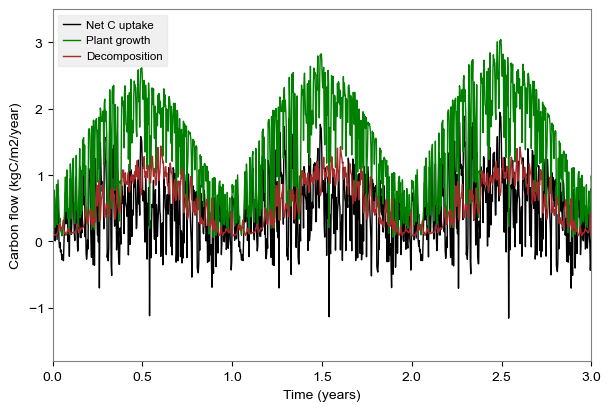

In [22]:
f,a=plt.subplots(nrows=1,clear=True,num='Fluxes',dpi=100)
t=np.arange(nsteps,dtype=float)/365;
a.plot(t,-baseline['Rh']-baseline['Ra']+baseline['photosynthesis'],c='k',label='Net C uptake')
a.plot(t,baseline['photosynthesis'],'g',label='Plant growth')
a.plot(t,baseline['Rh'],c='brown',label='Decomposition')
a.set_xlim(0,3)
a.set_ylim(-1.8,3.5)
a.legend()
a.set_xlabel('Time (years)')
a.set_ylabel('Carbon flow (kgC/m2/year)')